<div style="font-family: Calibri; font-size: 16px; background-color: #ccd5ae; padding: 10px 10px;">
    <h1>Feature Selection</h1>
</div>

In [19]:
import pandas as pd
import numpy as np
import warnings
from sklearn import set_config
from sklearn.dummy import DummyClassifier
from scripts.plot import plot_two_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from scripts.plot_tetha import plot_model
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, make_scorer, confusion_matrix, fbeta_score

In [20]:
warnings.filterwarnings("ignore") 
set_config(display='diagram')
pd.options.display.precision=3
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<div style="font-family: Calibri; font-size: 16px; background-color: #faedcd; padding: 5px;">
    <h2>1. Loading Train and Test dataset</h2>
    <p>Train-Test split is not required, as both dataset provided are separate.</p>
</div>

In [21]:
df = pd.read_csv("data/train.csv" )
df.head(2)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.230,36,0.440,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.810,60,0.680,Master's,Full-time,Married,No,No,Other,Yes,0


In [22]:
X_train = df.drop(columns=['Default', 'LoanID', 'DTIRatio', 'CreditScore'])
y_train = df['Default']

In [23]:
df_test = pd.read_csv("data/test.csv")

In [24]:
X_test = df.drop(columns=['Default', 'LoanID', 'DTIRatio', 'CreditScore'])
y_test = df['Default']

<hr>
<div style="font-family: Calibri; font-size: 16px; background-color: #faedcd; padding: 5px 5px 5px 5px;">
    <h2>2. Column Transformation</h2>
</div>

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

<div style="font-family: Calibri; font-size: 18px; background-color: #fefae0; padding: 3px 3px 3px 10px;">
    <h3>Univariate Analysis - Conclusion (Recap)</h3>    
    <ul>
            <li>HasCoSigner, HasDependents, HasMortgage are binary fields</li>
            <li>Education, EmploymentType, LoanPurpose, MaritalStatus are categorical data</li>
    </ul>        
    <h4>Transformation is done external to pipeline to avoid the redundent step In GridSearchCV
    </h4>
</div>

In [26]:
transformer = ColumnTransformer(
    [
        ('Binary', OneHotEncoder(), ['HasCoSigner', 'HasDependents', 'HasMortgage']),
        ('multi_category', OneHotEncoder(),  ['Education', 'EmploymentType', 'MaritalStatus']),
        ('Loan_category', OneHotEncoder(categories = [['Business', 'Home']], handle_unknown='ignore'), ['LoanPurpose']),    
    ], remainder=MinMaxScaler()
)

In [27]:
X_train = transformer.fit_transform(X_train)

In [28]:
X_test = transformer.transform(X_test)

<div style="font-family: Calibri; font-size: 16px; background-color: #faedcd; padding: 5px;">
    <font size=4>
    <ul>
        <li>KNearestNeighbor</li>
        <li>GridSearchCV</li>
    </ul>
    </font>
</div>

In [30]:
from sklearn.neighbors import KNeighborsClassifier

In [31]:
knn = KNeighborsClassifier()

In [32]:
param_grid = {
    'n_neighbors': list(range(5, 16, 2)),
    'weights': ['uniform', 'distance']
}

In [33]:
cv = GridSearchCV(knn, param_grid, cv=5, scoring='recall', n_jobs=-1)

In [34]:
cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 7, 9, 11, 13, 15],
                         'weights': ['uniform', 'distance']},
             scoring='recall')

In [ ]:
from sc

In [68]:
train_acc_list, test_acc_list, rs_list, ps_list, f1_list, ac_list = [],[],[],[],[],[]
TN_list, FP_list, FN_list, TP_list = [],[],[],[]

In [69]:
y_train_pred_prob, y_test_pred_prob = calc_predict_proba(knn, X_train, y_train, X_test, y_test)

In [70]:
for i in np.arange(0.3, 0.8, 0.1):
    train_acc, test_acc, rs, ps, f1, ac, y_test_pred = calc_scores(y_train, y_train_pred_prob, y_test, y_test_pred_prob, threshold = i)
    TN, FP, FN, TP = confusion_matrix_display(y_test, y_test_pred)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    rs_list.append(rs)
    ps_list.append(ps)
    f1_list.append(f1)
    ac_list.append(ac)
    TN_list.append(TN)
    FP_list.append(FP)
    FN_list.append(FN)
    TP_list.append(TP)

In [71]:
scores = pd.DataFrame({"train_accuracy_score": train_acc_list,
                       "test_accuracy_score": test_acc_list,
                       "recall_score": rs_list,
                       "precision_score": ps_list,
                       "f1_score": f1_list,
                       "accuracy_score": ac_list})

In [72]:
scores

,train_accuracy_score,test_accuracy_score,recall_score,precision_score,f1_score,accuracy_score
0,0.894,0.894,0.500,0.495,0.497,0.883
1,0.894,0.894,0.154,0.696,0.252,0.894
2,0.894,0.894,0.154,0.696,0.252,0.894
3,0.894,0.894,0.028,0.872,0.055,0.887
4,0.894,0.894,0.028,0.872,0.055,0.887


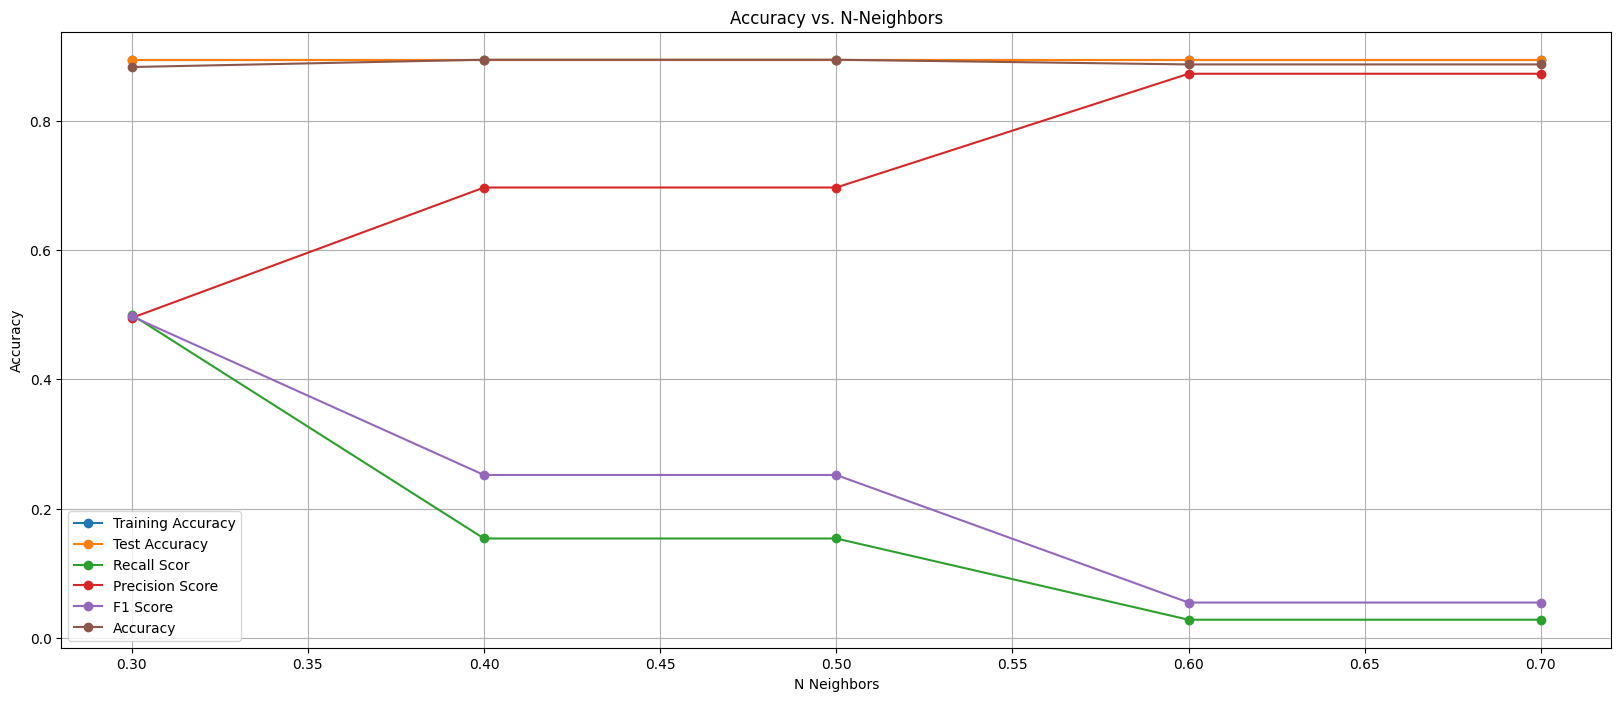

In [73]:
plt.figure(figsize=(20, 8))
plt.plot(np.arange(0.3, 0.8, 0.1),train_acc_list, label='Training Accuracy', marker='o')
plt.plot(np.arange(0.3, 0.8, 0.1),test_acc_list, label='Test Accuracy', marker='o')
plt.plot(np.arange(0.3, 0.8, 0.1),rs_list, label='Recall Scor', marker='o')
plt.plot(np.arange(0.3, 0.8, 0.1),ps_list, label='Precision Score', marker='o')
plt.plot(np.arange(0.3, 0.8, 0.1),f1_list, label='F1 Score', marker='o')
plt.plot(np.arange(0.3, 0.8, 0.1),ac_list, label='Accuracy', marker='o')
plt.xlabel('N Neighbors')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. N-Neighbors')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
conf_nbrs = pd.DataFrame({"TN": TN_list, "FP": FP_list, "FN": FN_list, "TP": TP_list}, index = np.arange(0.3, 0.8, 0.1))

In [75]:
conf_nbrs

,TN,FP,FN,TP
0.300,210566,15128,14832,14821
0.400,223705,1989,25090,4563
0.500,223705,1989,25090,4563
0.600,225571,123,28813,840
0.700,225571,123,28813,840


In [78]:
params1 = {
    'n_neighbors': list(range(5, 16, 2)),
    'weights':['uniform','distance']
}

In [81]:
cv1 = GridSearchCV(knn, param_grid=params1, n_jobs=-1, verbose=True, scoring='recall')

In [83]:
cv1.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [5, 7, 9, 11, 13, 15]},
             scoring='recall', verbose=True)

In [85]:
print(cv1.best_params_)

{'n_neighbors': 5}


ImportError: cannot import name 'plot_model' from 'scripts.plot_tetha' (/Users/c.gandhi/Berkley/LoanGuard_AI/scripts/plot_tetha.py)